**Gesture Recognition**

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
#Import all libraries
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
#from cv2 import resize
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, Activation, MaxPooling3D, BatchNormalization, Flatten, Dense, Dropout
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Project_data

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

Exploring the data

In [ ]:
#Exploring the data
import pandas as pd

df_data = pd.DataFrame()
#Creating empty list containers for video, action, and class
videos = []
actions = []
classes = []

#Traversing through the csv file and splitting video name into meaningful details and filling in lists
for video in train_doc:
  vidDetails = video.split(';')
  videos.append(vidDetails[0])
  actions.append(vidDetails[1])
  classes.append(vidDetails[2].strip())

#Populating the dataframe with names of videos, action happening in them, and the class
df_data['Video'] = videos
df_data['Action'] = actions
df_data['Class'] = classes

df_data.head()

,Video,Action,Class
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


<Axes: >

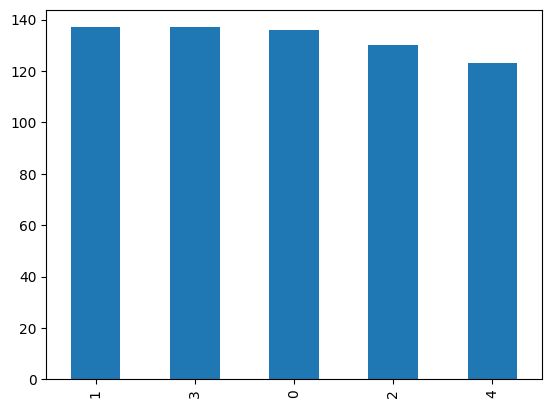

In [ ]:
#Checking for data imbalance
df_data.Class.value_counts().plot(kind = 'bar')

In [ ]:
#Reading and checking shape of one random image from the data
testImg = imread('Project_data/train/WIN_20180926_16_51_21_Pro_Thumbs_Down_new/WIN_20180926_16_51_21_Pro_00017.png')#.astype(np.float32)
testImg.shape

<ipython-input-9-1907a4f4136c>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  testImg = imread('Project_data/train/WIN_20180926_16_51_21_Pro_Thumbs_Down_new/WIN_20180926_16_51_21_Pro_00017.png')#.astype(np.float32)


(120, 160, 3)

In [ ]:
testImg[:2,:2,1]

Array([[127, 126],
       [127, 126]], dtype=uint8)

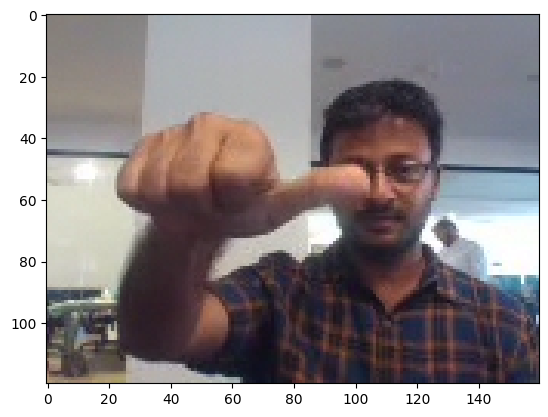

In [ ]:
#Printing the image
plt.imshow(testImg)

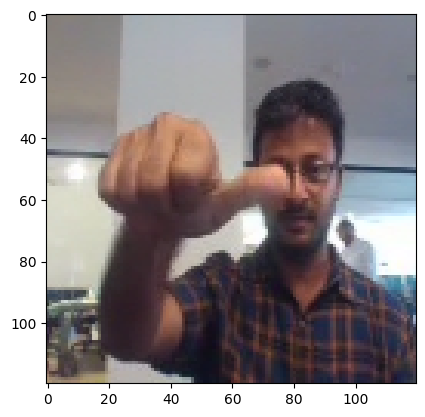

In [ ]:
#Resizing the image and printing again
testImg = resize(testImg,(120,120))
plt.imshow(testImg)

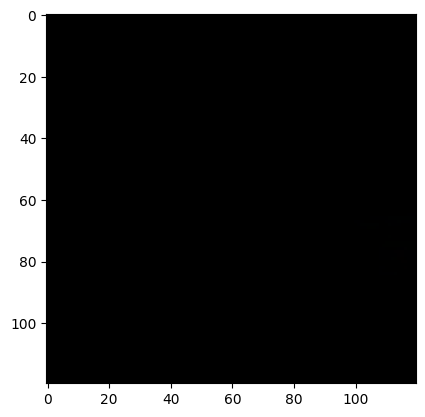

In [ ]:
#Normalizing the image and printing again
testImgN = testImg/255
plt.imshow(testImgN)

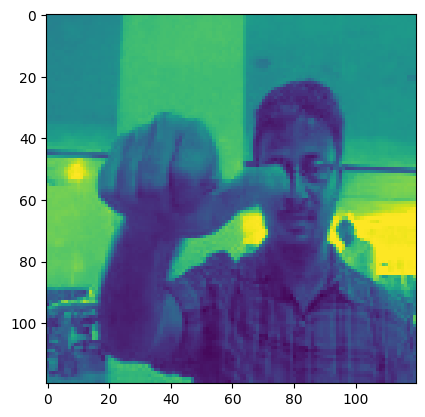

In [ ]:
#Printing one channel of the resized and normalized image
plt.imshow(testImgN[:,:,2])

In [ ]:
#Find the mean of each channel throughout the train data
import glob
# Initialize channel sums
red_sum = 0
blue_sum = 0
green_sum = 0
total_images = 0

# Define the data directory
data_dir = 'Project_data/train'

# Loop through all image files
for subdir, _, files in os.walk(data_dir):
    for file in glob.glob(os.path.join(subdir, "*.png")):
        image = imread(file).astype(np.float32)
        red_sum += np.mean(image[:, :, 0])
        blue_sum += np.mean(image[:, :, 1])
        green_sum += np.mean(image[:, :, 2])
        total_images += 1

# Calculate mean values for each channel
mean_red = red_sum / total_images
mean_blue = blue_sum / total_images
mean_green = green_sum / total_images

# Print results
print('Total Images =', total_images)
print('Mean Red Channel:', mean_red)
print('Mean Blue Channel:', mean_blue)
print('Mean Green Channel:', mean_green)

<ipython-input-15-a57cab795d44>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file).astype(np.float32)


Total Images = 19890
Mean Red Channel: 123.50432210205906
Mean Blue Channel: 113.3637943942922
Mean Green Channel: 108.86645588901187


Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size, num_frames, img_height, img_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,num_frames)).astype(int)#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = img_height
    z = img_width
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        #print('DNA logs - Number of batches to produce = ' + str(num_batches))
        for batch in range(num_batches): # we iterate over the number of batches
            #print('DNA logs - batch being processed = ' + str(batch))
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print('    DNA logs - video being processed for current batch = ' + str(folder))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('        DNA logs - Image being processed for current video = ' + str(idx))
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 127.76 # /255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 127.76 # /255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 127.76 # /255.0 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        # Reutilizing batch variable from above to keep a track of the last batch to be processed
        last_batch_size = len(t)%batch_size
        #print('DNA logs - Last batch size = ' + str(last_batch_size))
        if last_batch_size > 0:
          batch_data = np.zeros((last_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(last_batch_size): # iterate over the batch_size
              #print('DNA logs - Iterating for last batch on video number - ' + str(folder))
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*last_batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                  #crop the images and resize them. Note that the images are of 2 different shape
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  if image.shape[1] == 160:
                      image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                  else:
                      image = resize(image,(y,z)).astype(np.float32)

                  batch_data[folder,idx,:,:,0] = image[:,:,0] - 127.76 #/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image[:,:,1] - 127.76 #/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image[:,:,2] - 127.76 #/255.0 #normalise and feed in the image

              batch_labels[folder, int(t[folder + (num_batches*last_batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
#Plotting performance

In [ ]:
def plot_performance(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


Model

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

Building of CONV3D model starts here
Conv3D Model 1 - Sample Model.
Finding highest batch size.
Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [ ]:
batch_size = 50
num_frames = 20
img_height = 120
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model

In [ ]:
model = Sequential()

model.add(Conv3D(16,
                 kernel_size=(3,3,3),
                 padding='same',
                 activation='relu',
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing the optimizer and compiling the model

In [ ]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 120, 120, 32)  13856     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                        

In [ ]:
#Creating the callback list along with the mechanism to save model weights

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
#Run 2 epoch to check the sanity, and to see if the batch size is okay
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              #epochs=num_epochs,
                              epochs=2,
                              verbose=1,
                              #callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  Project_data/train ; batch size = 50


<ipython-input-30-70e5575deaa7>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/2
12/14 [========================>.....] - ETA: 14s - loss: 1.7762 - categorical_accuracy: 0.4683

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - 157s 10s/step - loss: 1.7784 - categorical_accuracy: 0.4706 - val_loss: 61.8756 - val_categorical_accuracy: 0.2300
Epoch 2/2
14/14 [==============================] - 131s 10s/step - loss: 1.1517 - categorical_accuracy: 0.5671 - val_loss: 28.2000 - val_categorical_accuracy: 0.1800


Conv3D Model 2 - 1st model to run for full epochs

In [ ]:
num_epochs = 20
batch_size = 40
num_frames = 20
img_height = 120
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the model structual
model = Sequential()

model.add(Conv3D(16,
                 kernel_size=(3,3,3),
                 padding='same',
                 activation='relu',
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_3 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  13856     
                                                                 
 batch_normalization_4 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                      

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


Source path =  Project_data/train ; batch size = 40


<ipython-input-36-15bdd5c0c51e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
15/17 [=========================>....] - ETA: 12s - loss: 1.9603 - categorical_accuracy: 0.3933

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.9491 - categorical_accuracy: 0.3982Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2023-08-1002_30_56.399257/model-00001-1.94909-0.39819-31.01049-0.27000.h5
17/17 [==============================] - 156s 9s/step - loss: 1.9491 - categorical_accuracy: 0.3982 - val_loss: 31.0105 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.0567 - categorical_accuracy: 0.5897
Epoch 2: saving model to model_init_2023-08-1002_30_56.399257/model-00002-1.05669-0.58974-10.87743-0.23000.h5
17/17 [==============================] - 137s 8s/step - loss: 1.0567 - categorical_accuracy: 0.5897 - val_loss: 10.8774 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.8850 - categorical_accuracy: 0.7149
Epoch 3: saving model to model_init_2023-08-1002_30_56.399257/model-00003-0.88505-0.714

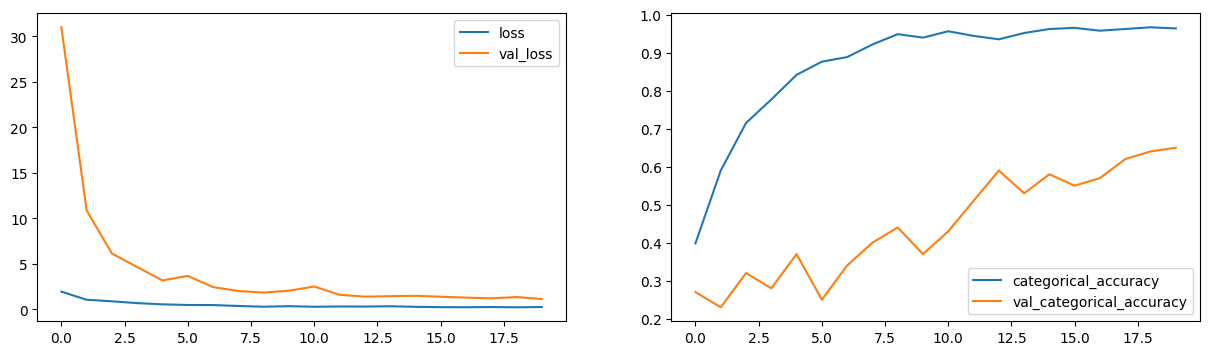

In [ ]:
#Let us now fit the model and plot accuracy and loss.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)

Conv3D Model 3 - Changing the architecture and adding more layers. Previous one is not converging

In [ ]:
# All hyperparameters are unchanged so we can reutilize the previous generator instance

#Building the structure of model
model = Sequential()

model.add(Conv3D(16,
                 kernel_size=(3,3,3),
                 padding='same',
                 activation='relu',
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_7 (Batc  (None, 10, 60, 60, 32)   128       
 hNormalization)                                                 
                                                      

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
#We can resuse the previous steps_per_epoch and validation_steps as hyperparameters are unchanged

<ipython-input-40-15bdd5c0c51e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
14/17 [=======================>......] - ETA: 17s - loss: 1.2543 - categorical_accuracy: 0.5071

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.2345 - categorical_accuracy: 0.5294
Epoch 1: saving model to Conv3D_Model_3_2023-08-1002_30_56.399257/model-00001-1.23445-0.52941-38.61851-0.22000.h5
17/17 [==============================] - 127s 7s/step - loss: 1.2345 - categorical_accuracy: 0.5294 - val_loss: 38.6185 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.7114 - categorical_accuracy: 0.7783
Epoch 2: saving model to Conv3D_Model_3_2023-08-1002_30_56.399257/model-00002-0.71140-0.77828-15.72290-0.21000.h5
17/17 [==============================] - 138s 9s/step - loss: 0.7114 - categorical_accuracy: 0.7783 - val_loss: 15.7229 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.5105 - categorical_accuracy: 0.8793
Epoch 3: saving model to Conv3D_Model_3_2023-08-1002_30_56.399257/model-00003-0.51051-0.87934-6.53237-0.19000.h5
17/17 [=========

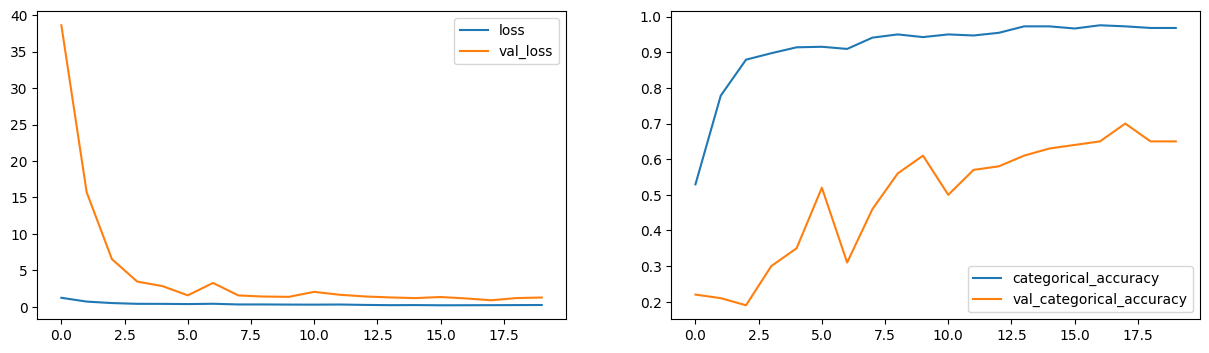

In [ ]:
#Let us now fit the model and plot accuracy and loss.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)

In [ ]:
#Model is overfitting

Conv3D Model 4 - Previous model architecture but with smaller batch size

In [ ]:
num_epochs = 20
batch_size = 25
num_frames = 20
img_height = 120
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

<ipython-input-43-ef5990297cb8>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 25
Epoch 1/20
25/27 [==========================>...] - ETA: 7s - loss: 0.0821 - categorical_accuracy: 0.9968 

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


27/27 [==============================] - ETA: 0s - loss: 0.1540 - categorical_accuracy: 0.9804Source path =  Project_data/val ; batch size = 25

Epoch 1: saving model to Conv3D_Model_4_2023-08-1002_30_56.399257/model-00001-0.15403-0.98039-0.67537-0.76000.h5
27/27 [==============================] - 135s 5s/step - loss: 0.1540 - categorical_accuracy: 0.9804 - val_loss: 0.6754 - val_categorical_accuracy: 0.7600 - lr: 4.0000e-05
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.1355 - categorical_accuracy: 0.9849
Epoch 2: saving model to Conv3D_Model_4_2023-08-1002_30_56.399257/model-00002-0.13554-0.98492-0.58414-0.77000.h5
27/27 [==============================] - 123s 5s/step - loss: 0.1355 - categorical_accuracy: 0.9849 - val_loss: 0.5841 - val_categorical_accuracy: 0.7700 - lr: 4.0000e-05
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.1385 - categorical_accuracy: 0.9849
Epoch 3: saving model to Conv3D_Model_4_2023-08-1002_30_56.399257/model-000

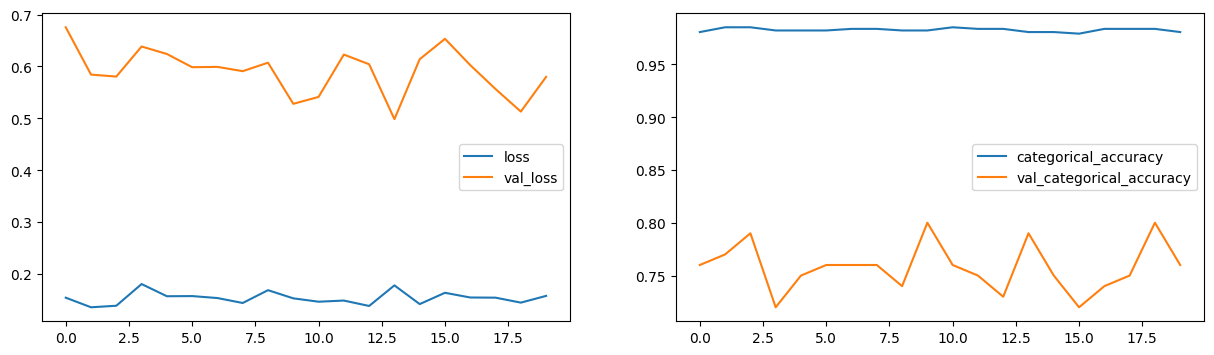

In [ ]:
#Reuse previous model, change only batch size

#Model is already compiled

#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#Let us now fit the model and plot accuracy and loss.
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)

In [ ]:
#The model is too complex for the data that We need a simpler model that does not overfit

Conv3D_Model_5 - Create a new architecture with batch size of 40

In [ ]:
num_epochs = 20
batch_size = 40
num_frames = 20
img_height = 120
img_width = 120
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the model structure
model = Sequential()

model.add(BatchNormalization(input_shape=(num_frames,img_height,img_width,3)))
model.add(Conv3D(16,
                 kernel_size=(3,3,3),
                 padding='same',
                 activation='relu',
                 kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,
                 kernel_size=(3,3,3),
                 padding='same',
                 activation='relu',
                 kernel_initializer='he_uniform',))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 20, 120, 120, 3)  12        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 30, 30, 32)    0         
 3D)                                                             
                                                      

Source path =  Project_data/train ; batch size = 40


<ipython-input-47-e29f840ec43b>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
15/17 [=========================>....] - ETA: 12s - loss: 30.1632 - categorical_accuracy: 0.2067

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 27.4979 - categorical_accuracy: 0.2066Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to Conv3D_Model_5_2023-08-1002_30_56.399257/model-00001-27.49792-0.20664-2.40427-0.23000.h5
17/17 [==============================] - 132s 8s/step - loss: 27.4979 - categorical_accuracy: 0.2066 - val_loss: 2.4043 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.2368
Epoch 2: saving model to Conv3D_Model_5_2023-08-1002_30_56.399257/model-00002-1.60978-0.23680-1.59853-0.25000.h5
17/17 [==============================] - 134s 8s/step - loss: 1.6098 - categorical_accuracy: 0.2368 - val_loss: 1.5985 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5878 - categorical_accuracy: 0.3122
Epoch 3: saving model to Conv3D_Model_5_2023-08-1002_30_56.399257/model-00003-1.

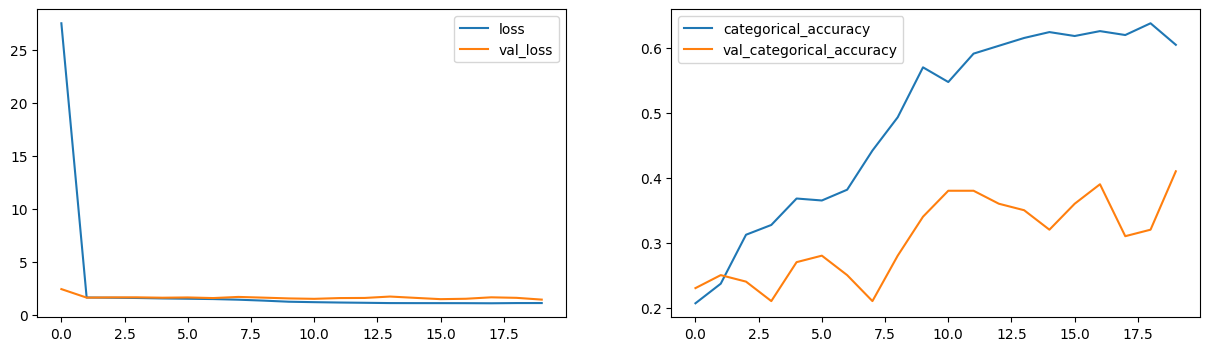

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let's fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)

In [ ]:
#Model needs improvement

Conv3D_Model_6 - Making changes in the model architecture and keeping less layers.

In [ ]:
num_epochs = 20
batch_size = 40
num_frames = 20
img_height = 80
img_width = 80
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the model structure
model = Sequential()

model.add(Conv3D(16,
                 kernel_size=(2,2,2),
                 padding='same',
                 activation='relu',
                 kernel_initializer='he_uniform',
                 input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,
                kernel_size=(3,3,3),
                padding='same',
                activation='relu',
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 20, 80, 80, 16)    400       
                                                                 
 batch_normalization_11 (Bat  (None, 20, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 40, 40, 16)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_12 (Bat  (None, 10, 40, 40, 32)   128       
 chNormalization)                                                
                                                      

Source path =  Project_data/train ; batch size = 40


<ipython-input-52-3f61d015b5c2>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
16/17 [===========================>..] - ETA: 5s - loss: 1.5344 - categorical_accuracy: 0.4625 

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.5826 - categorical_accuracy: 0.4510Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to Conv3D_Model_6_2023-08-1002_30_56.399257/model-00001-1.58263-0.45098-50.95031-0.22000.h5
17/17 [==============================] - 129s 8s/step - loss: 1.5826 - categorical_accuracy: 0.4510 - val_loss: 50.9503 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.7924 - categorical_accuracy: 0.7059
Epoch 2: saving model to Conv3D_Model_6_2023-08-1002_30_56.399257/model-00002-0.79244-0.70588-12.25150-0.32000.h5
17/17 [==============================] - 136s 8s/step - loss: 0.7924 - categorical_accuracy: 0.7059 - val_loss: 12.2515 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.6194 - categorical_accuracy: 0.8250
Epoch 3: saving model to Conv3D_Model_6_2023-08-1002_30_56.399257/model-00003-0

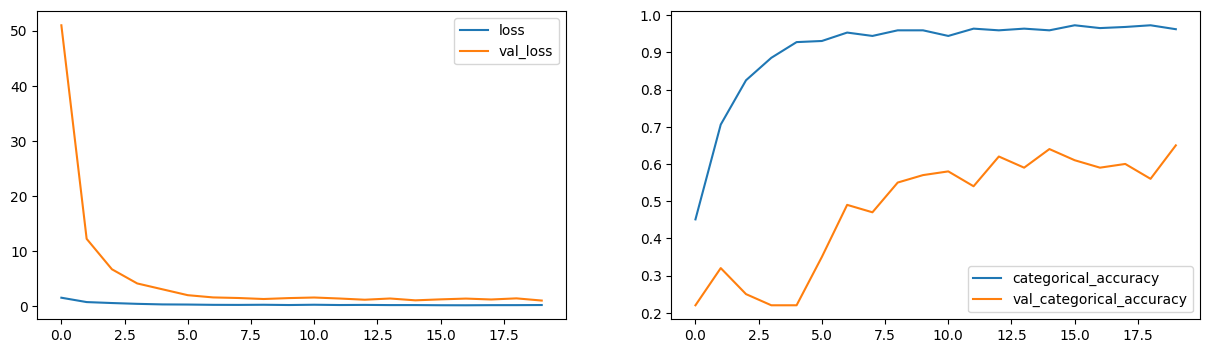

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)

Conv3D_Model_7 - Changing the architecture, taking a higher batch size, reducing number of frames and image size, and running for 20 epochs

In [ ]:
#Choosing elu instead of Relu to avoid Dying Relu problem causing the model to fail completely and not learn

In [ ]:
num_epochs = 20
batch_size = 40
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the model structure
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_14 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 9, 42, 84, 64)    0         
 3D)                                                             
                                                                 
 conv3d_12 (Conv3D)          (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_15 (Bat  (None, 9, 42, 84, 128)  

<ipython-input-56-46ac65f40db3>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 40
Epoch 1/20
15/17 [=========================>....] - ETA: 11s - loss: 26.1529 - categorical_accuracy: 0.2283

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 23.9791 - categorical_accuracy: 0.2247Source path =  Project_data/val ; batch size = 40

Epoch 1: val_loss improved from inf to 12.15811, saving model to Conv3D_Model_7_2023-08-1002_30_56.399257/model-00001-23.97906-0.22474-12.15811-0.21000.h5
17/17 [==============================] - 148s 8s/step - loss: 23.9791 - categorical_accuracy: 0.2247 - val_loss: 12.1581 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 2.3350 - categorical_accuracy: 0.3484
Epoch 2: val_loss improved from 12.15811 to 5.70078, saving model to Conv3D_Model_7_2023-08-1002_30_56.399257/model-00002-2.33504-0.34842-5.70078-0.32000.h5
17/17 [==============================] - 144s 9s/step - loss: 2.3350 - categorical_accuracy: 0.3484 - val_loss: 5.7008 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5960 - categorical_accuracy: 0

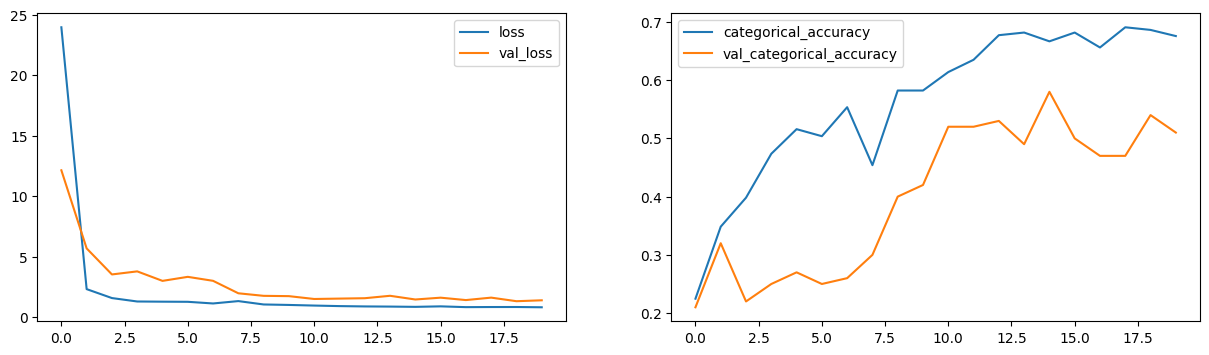

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)


In [ ]:
#The model is still highly overfitting.

Conv3D_Model_8 - Making the architecture simpler

In [ ]:
#Keeping the hyperparameters same

In [ ]:
num_epochs = 20
batch_size = 60
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu'))
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 18, 84, 84, 16)    1312      
                                                                 
 activation_3 (Activation)   (None, 18, 84, 84, 16)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 42, 84, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 9, 42, 84, 32)     13856     
                                                                 
 activation_4 (Activation)   (None, 9, 42, 84, 32)     0         
                                                                 
 batch_normalization_17 (Bat  (None, 9, 42, 84, 32)    128       
 chNormalization)                                     

<ipython-input-61-1475f9a6d039>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 60
Epoch 1/20
10/12 [========================>.....] - ETA: 16s - loss: 6.8682 - categorical_accuracy: 0.2917

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


12/12 [==============================] - ETA: 0s - loss: 6.3553 - categorical_accuracy: 0.3077Source path =  Project_data/val ; batch size = 60

Epoch 1: val_loss improved from inf to 13.17429, saving model to Conv3D_Model_8_2023-08-1002_30_56.399257/model-00001-6.35531-0.30769-13.17429-0.25000.h5
12/12 [==============================] - 120s 10s/step - loss: 6.3553 - categorical_accuracy: 0.3077 - val_loss: 13.1743 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.5729 - categorical_accuracy: 0.4419
Epoch 2: val_loss improved from 13.17429 to 4.83967, saving model to Conv3D_Model_8_2023-08-1002_30_56.399257/model-00002-1.57285-0.44193-4.83967-0.24000.h5
12/12 [==============================] - 116s 11s/step - loss: 1.5729 - categorical_accuracy: 0.4419 - val_loss: 4.8397 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/20
11/12 [==========================>...] - ETA: 8s - loss: 1.2235 - categorical_accuracy: 0.

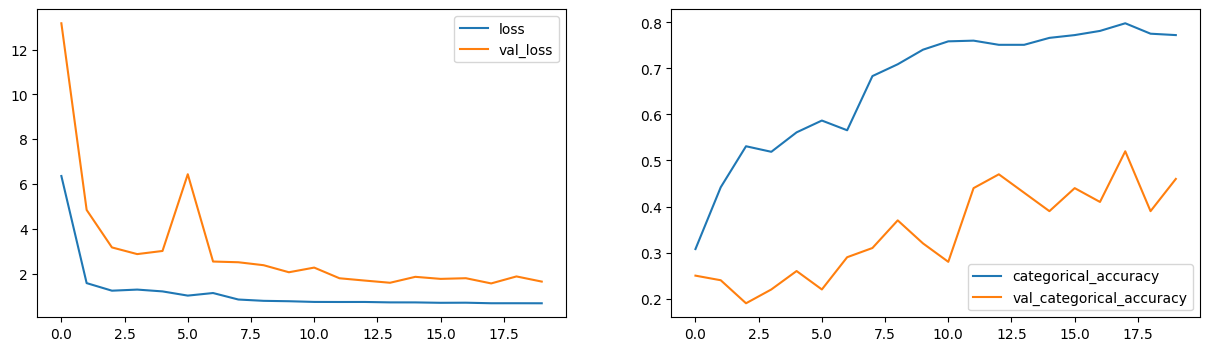

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)
plot_performance(history)


Conv3D_Model_9 - Trying to build another model, this time the normalization technique has been changed in the generator.

In [ ]:
#trying to keep the parameters minimum so that the model is light

In [ ]:
num_epochs = 20
batch_size = 20
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 16)   64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 84, 32)    1

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=2,
                       cooldown=1,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)



<ipython-input-24-355779987ee5>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 20
Epoch 1/20
33/34 [============================>.] - ETA: 2s - loss: 3.3431 - categorical_accuracy: 0.2697

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 [==============================] - ETA: 0s - loss: 3.3387 - categorical_accuracy: 0.2685Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 2.20784, saving model to Conv3D_Model_9_2023-08-1010_20_26.203291/model-00001-3.33867-0.26848-2.20784-0.22000.h5
34/34 [==============================] - 122s 3s/step - loss: 3.3387 - categorical_accuracy: 0.2685 - val_loss: 2.2078 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4609 - categorical_accuracy: 0.3786
Epoch 2: val_loss improved from 2.20784 to 2.15534, saving model to Conv3D_Model_9_2023-08-1010_20_26.203291/model-00002-1.46086-0.37858-2.15534-0.28000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.4609 - categorical_accuracy: 0.3786 - val_loss: 2.1553 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.2488 - categorical_accuracy: 0.4902
Ep

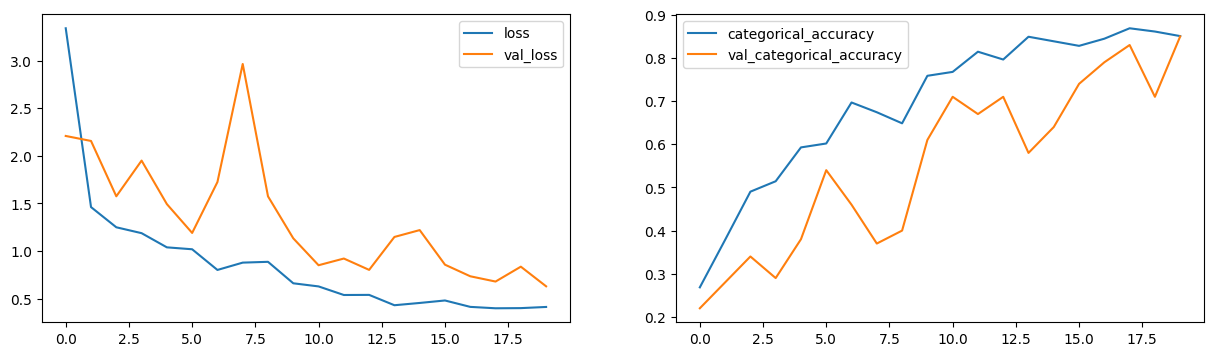

In [ ]:
plot_performance(history)

In [ ]:
#This is a better model.
#If we make the model more complex, it can be more accurate but it will also consume more memory. We can try a few more variations ahead.

Conv3D_Model_10 - Trying to reduce the parameters further, while making the model deeper

In [ ]:
num_epochs = 25
batch_size = 20
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model
model = Sequential()
model.add(Conv3D(8, (3,3,3), strides=(1,1,1), padding='same', input_shape=(num_frames,img_height,img_width,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 84, 84, 8)     656       
                                                                 
 batch_normalization_3 (Batc  (None, 18, 84, 84, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 18, 84, 84, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 42, 84, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 42, 84, 16)     3472      
                                                                 
 batch_normalization_4 (Batc  (None, 9, 42, 84, 16)   

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'Conv3D_Model_10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=2,
                       cooldown=1,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)



<ipython-input-29-2ceae4faaa81>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 20
Epoch 1/25
33/34 [============================>.] - ETA: 2s - loss: 1.4215 - categorical_accuracy: 0.4561

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 [==============================] - ETA: 0s - loss: 1.4355 - categorical_accuracy: 0.4540Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 5.34944, saving model to Conv3D_Model_10_2023-08-1010_20_26.203291/model-00001-1.43546-0.45400-5.34944-0.22000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.4355 - categorical_accuracy: 0.4540 - val_loss: 5.3494 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1813 - categorical_accuracy: 0.5339
Epoch 2: val_loss improved from 5.34944 to 4.47283, saving model to Conv3D_Model_10_2023-08-1010_20_26.203291/model-00002-1.18129-0.53394-4.47283-0.19000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.1813 - categorical_accuracy: 0.5339 - val_loss: 4.4728 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9607 - categorical_accuracy: 0.6124


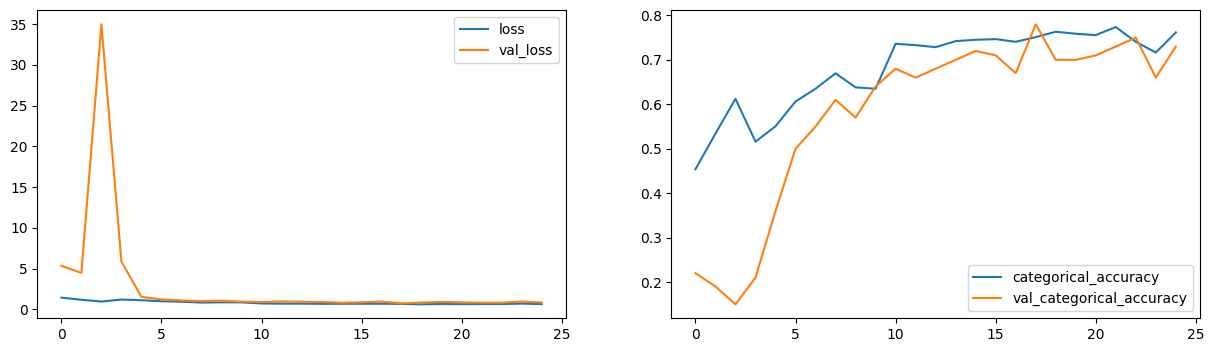

In [ ]:
plot_performance(history)

In [ ]:
#We can see that after the 18th epoch, we have got the best results. Training categorical_accuracy: 75% , and validation categorical_accuracy: 78%.
#This model also has least number of parameters so it is lightweight and occupies less memory. It's performance is not excellent but it should be considered if we want a small and lightweight model

Building of CNN+RNN model starts here

CNN_RNN_Model1 - This is a CNN + RNN(GRU) model

In [ ]:
num_epochs = 20
batch_size = 20
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
#Building the structure of model

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 84, 84, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 84, 84, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 42, 42, 32)  

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_Model1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=2,
                       cooldown=1,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)


<ipython-input-35-e1e877a97ca5>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 20
Epoch 1/20
33/34 [============================>.] - ETA: 2s - loss: 1.5128 - categorical_accuracy: 0.3424

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 [==============================] - ETA: 0s - loss: 1.5116 - categorical_accuracy: 0.3439Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.67843, saving model to CNN_RNN_Model1_2023-08-1010_20_26.203291/model-00001-1.51161-0.34389-1.67843-0.30000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.5116 - categorical_accuracy: 0.3439 - val_loss: 1.6784 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1610 - categorical_accuracy: 0.5173
Epoch 2: val_loss did not improve from 1.67843
34/34 [==============================] - 101s 3s/step - loss: 1.1610 - categorical_accuracy: 0.5173 - val_loss: 1.8686 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8790 - categorical_accuracy: 0.6516
Epoch 3: val_loss did not improve from 1.67843

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999

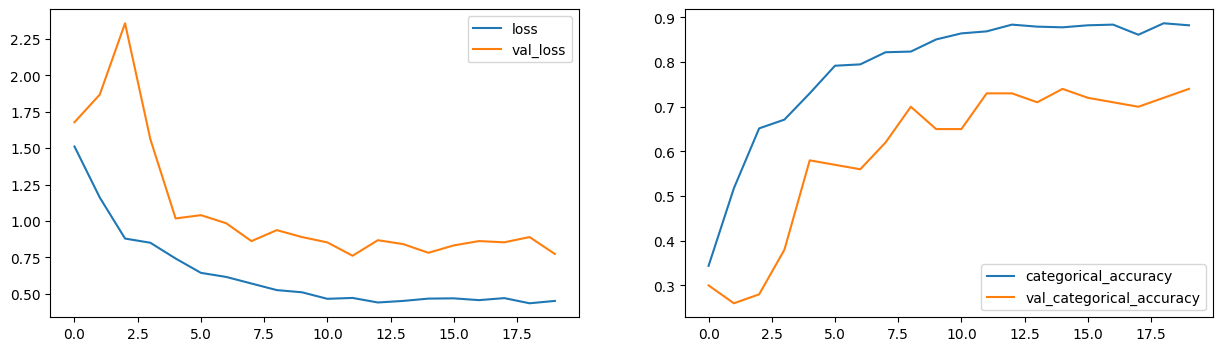

In [ ]:
plot_performance(history)

In [ ]:
#CNN_RNN_Model2 - Trying to reduce the parameters to reduce the model size

In [ ]:
num_epochs = 20
batch_size = 20
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 18, 84, 84, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 18, 84, 84, 8)    32        
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 18, 42, 42, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 18, 42, 42, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 42, 42, 16)  

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_Model2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=2,
                       cooldown=1,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)


<ipython-input-41-2cdff048c08e>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 20
Epoch 1/20
33/34 [============================>.] - ETA: 2s - loss: 1.6112 - categorical_accuracy: 0.2712

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 [==============================] - ETA: 0s - loss: 1.6128 - categorical_accuracy: 0.2700Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.61744, saving model to CNN_RNN_Model2_2023-08-1010_20_26.203291/model-00001-1.61282-0.26998-1.61744-0.33000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.6128 - categorical_accuracy: 0.2700 - val_loss: 1.6174 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3768 - categorical_accuracy: 0.4299
Epoch 2: val_loss improved from 1.61744 to 1.57836, saving model to CNN_RNN_Model2_2023-08-1010_20_26.203291/model-00002-1.37677-0.42986-1.57836-0.29000.h5
34/34 [==============================] - 101s 3s/step - loss: 1.3768 - categorical_accuracy: 0.4299 - val_loss: 1.5784 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1999 - categorical_accuracy: 0.5189
E

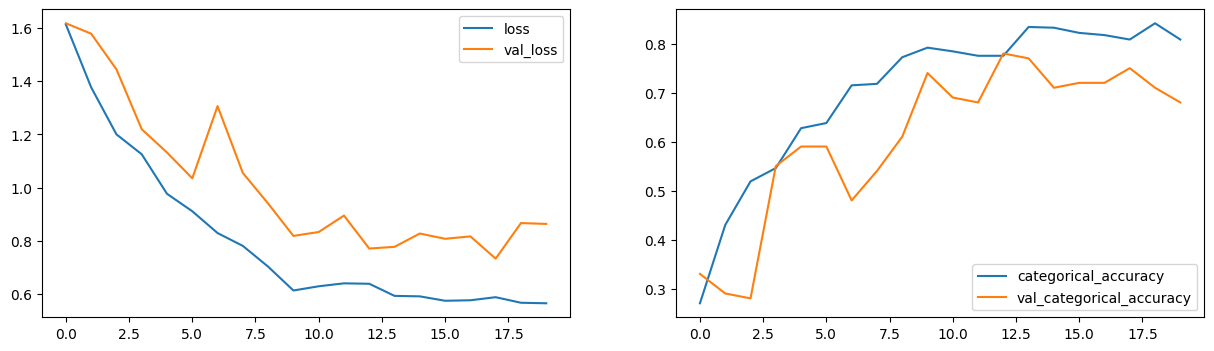

In [ ]:
plot_performance(history)

In [ ]:
#This one is a considerably lighter model with less parameters.The performance is not too great but this is a better model than the previous one.

In [ ]:
#CNN_RNN_TL_Model3 - CNN + RNN with Transfer learning

In [ ]:
num_epochs = 20
batch_size = 20
num_frames = 18
img_height = 84
img_width = 84
train_generator = generator(train_path, train_doc, batch_size, num_frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_frames, img_height, img_width)

In [ ]:
#Building the structure of model
from tensorflow.keras.applications import mobilenet
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

mobilenet_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 

In [ ]:
#Set pre-trained model layers to not trainable
for layer in mobilenet_model.layers:
    layer.trainable = False

In [ ]:
print(len(mobilenet_model.layers))

86


In [ ]:
for layer in model.layers[55:]:
    layer.trainable =  True

In [ ]:
model = Sequential()

model.add(TimeDistributed(mobilenet_model,input_shape=(num_frames,img_height,img_width,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


#Choosing the optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 18, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 18, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [ ]:
#Creating the callback list along with the mechanism to save model weights
model_name = 'CNN_RNN_TL_Model3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=2,
                       cooldown=1,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)


<ipython-input-51-88d1718be916>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
<ipython-input-16-cf15542b9454>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  Project_data/train ; batch size = 20
Epoch 1/20
33/34 [============================>.] - ETA: 2s - loss: 1.7116 - categorical_accuracy: 0.2030

<ipython-input-16-cf15542b9454>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


34/34 [==============================] - ETA: 0s - loss: 1.7113 - categorical_accuracy: 0.2036Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.61874, saving model to CNN_RNN_TL_Model3_2023-08-1010_20_26.203291/model-00001-1.71131-0.20362-1.61874-0.26000.h5
34/34 [==============================] - 113s 3s/step - loss: 1.7113 - categorical_accuracy: 0.2036 - val_loss: 1.6187 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5990 - categorical_accuracy: 0.2941
Epoch 2: val_loss improved from 1.61874 to 1.57219, saving model to CNN_RNN_TL_Model3_2023-08-1010_20_26.203291/model-00002-1.59897-0.29412-1.57219-0.34000.h5
34/34 [==============================] - 99s 3s/step - loss: 1.5990 - categorical_accuracy: 0.2941 - val_loss: 1.5722 - val_categorical_accuracy: 0.3400 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5214 - categorical_accuracy: 0.3

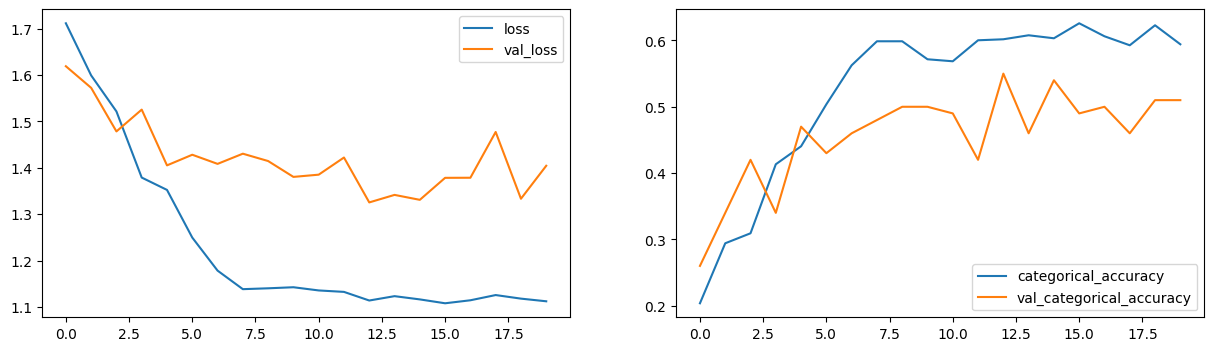

In [ ]:
plot_performance(history)

In [3]:
#This model has not learned well, and should not use